In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os
import shutil
import numpy as np
# from google.colab import drive


import torch
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

In [3]:
import pandas as pd

labeldf = pd.read_csv(r"x_ray_1000.csv")

display(labeldf)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000
1,00000008_002.png,Nodule,2,8,73,F,PA,2048,2500,0.168000,0.168000
2,00000011_000.png,Effusion,0,11,75,M,PA,2638,2449,0.143000,0.143000
3,00000011_007.png,Infiltration,7,11,75,M,PA,2782,2753,0.143000,0.143000
4,00000013_003.png,Pleural_Thickening,3,13,60,M,AP,2996,2544,0.139000,0.139000
...,...,...,...,...,...,...,...,...,...,...,...
9995,00030782_000.png,No Finding,0,30782,40,M,AP,3056,2544,0.139000,0.139000
9996,00030783_000.png,No Finding,0,30783,57,M,PA,2021,2021,0.194311,0.194311
9997,00030786_006.png,Consolidation,6,30786,61,F,AP,3056,2544,0.139000,0.139000
9998,00030787_000.png,No Finding,0,30787,34,M,PA,2021,2021,0.194311,0.194311


In [ ]:
#Preprocessing func
import os
import shutil
import numpy as np

# import torch
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

labels = labeldf[["Image Index","Finding Labels"]]
np.random.seed(seed=0)
mask = np.random.rand(len(labeldf)) < 0.8

train_labels = labels[mask]; test_labels = labels[~mask]

def restructureRawData(sourceFolder,targetFolder,refDF):
    '''
    @params 
    sourceFolder : Str - Path in string
    targetFolder : Str - Path in string
    redDF : DataFrame - Pandas df with FileName | Label

    Given a data folder and label csv,
    restructures the 10000 image files into a pytorch/fastai compatible folder schema for ImageDataBunch
    '''
    if not os.path.exists(targetFolder):
        os.makedirs(targetFolder)

    img_list =  os.listdir(sourceFolder)
    for i,j in refDF.values:
        if i in img_list:
            if not os.path.exists(targetFolder+'/'+j):
                os.makedirs(targetFolder+"/"+j)
                shutil.copy(sourceFolder+'/'+i, targetFolder+"/"+j+"/"+i)
            else:
                shutil.copy(sourceFolder+'/'+i, targetFolder+"/"+j+"/"+i)
# restructureRawData('xRayRawInput/x_ray_1000_images',"VM_input/train",train_labels)
# restructureRawData('xRayRawInput/x_ray_1000_images',"VM_input/valid",test_labels)

In [ ]:
# labels2 = labeldf[["Image Index","Finding Labels"]]
# np.random.seed(seed=0)
# mask = np.random.rand(len(labeldf)) < 0.8

# train_labels2 = labels[mask]; test_labels2 = labels[~mask]
# binTrain = train_labels2[(train_labels2["Finding Labels"]== "Cardiomegaly") | (train_labels2["Finding Labels"] == "No Finding") | (train_labels2["Finding Labels"] == "Effusion") | (train_labels2["Finding Labels"] == "Consolidation") | (train_labels2["Finding Labels"] == "Mass")]
# binTest = test_labels2[(test_labels2["Finding Labels"]== "Cardiomegaly") | (test_labels2["Finding Labels"] == "No Finding") | (test_labels2["Finding Labels"] == "Effusion") | (test_labels2["Finding Labels"] == "Consolidation") | (test_labels2["Finding Labels"] == "Mass")]

# # display(binTest)

# restructureRawData('/content/gdrive/My Drive/x_ray_1000_images',"keras_4classinput/train",binTrain)
# restructureRawData('/content/gdrive/My Drive/x_ray_1000_images',"keras_4classinput/valid",binTest)

In [ ]:
# Creating ImageDataBunch for pytorch based ResNets
path = "path to imagenet style partitioned folder"

tfms = get_transforms(do_flip=True, 
                      flip_vert=False, max_rotate = None, max_warp=0.1, 
                      xtra_tfms=rand_resize_crop(224))

data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224, bs=64).normalize(imagenet_stats)

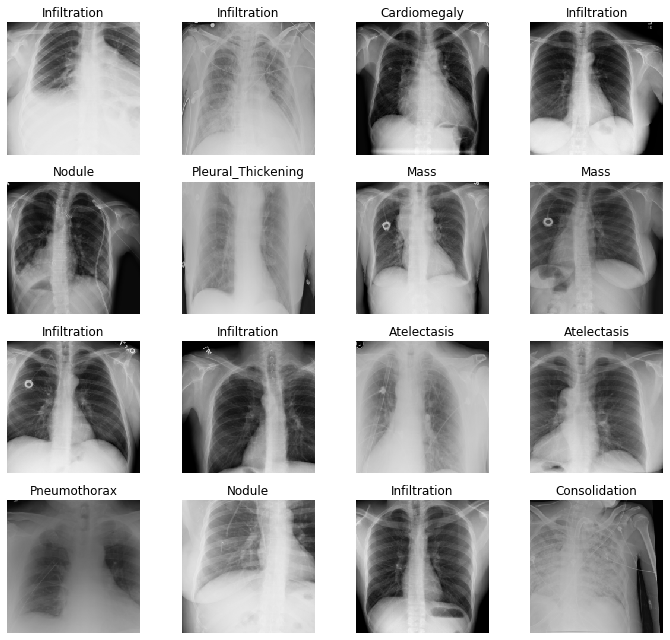

In [ ]:
data.show_batch(rows=4, figsize=(10,9))

In [8]:
print(data.classes)
len(data.classes),data.c

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Effusion', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumothorax']


(10, 10)

In [ ]:
# Instantiating metrics classes
precision = Precision(average='macro')
recall = Recall(average='macro')
F1 = FBeta(beta=1,average='macro')

learner = cnn_learner(data, models.resnet34, metrics=[accuracy,precision,recall,F1])

In [ ]:
learner.model

In [ ]:
defaults.device = torch.device('cuda') # makes sure the gpu is used

learner.unfreeze()

learner.fit_one_cycle(10)


epoch,train_loss,valid_loss,accuracy,time
0,0.720012,0.657547,0.728900,01:23
1,0.681773,0.748638,0.731458,01:22
2,0.594701,0.435139,0.787724,01:23
3,0.500656,0.361455,0.841432,01:22
4,0.429431,0.361606,0.833760,01:21


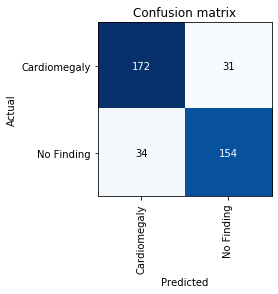

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

interp.plot_confusion_matrix()

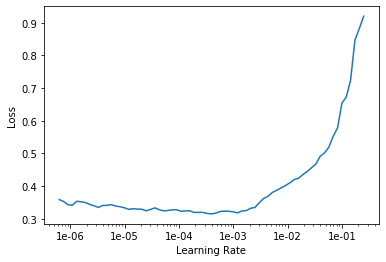

In [ ]:
# learner.lr_find()
learner.recorder.plot()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K


# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'keras_input/train'
validation_data_dir = 'keras_input/valid'
nb_train_samples = 1609
nb_validation_samples = 391
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('first_try.h5')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Found 1609 images belonging to 2 classes.
Found 391 images belonging to 2 classes.



Epoch 1/50





100/100 [==============================] - 711s 7s/step - loss: 0.6979 - acc: 0.4944 - val_loss: 0.6926 - val_acc: 0.5417
Epoch 2/50
100/100 [==============================] - 47s 466ms/step - loss: 0.6934 - acc: 0.5274 - val_loss: 0.6774 - val_acc: 0.5307
Epoch 3/50
100/100 [==============================] - 46s 458ms/step - loss: 0.6763 - acc: 0.5797 - val_loss: 0.6348 - val_acc: 0.6160
Epoch 4/50
100/100 [==============================] - 46s 460ms/step - loss: 0.6534 - acc: 0.6359 - val_loss: 0.6154 - val_acc: 0.6933
Epoch 5/50
100/100 [==============================] - 45s 455ms/step - loss: 0.6405 - acc: 0.6498 - val_loss: 0.5681 - val_acc: 0.7120
Epoch 6/50
100/100 [==============================] - 45s 450ms/step - loss: 0.6141 - acc: 0.6665 - val_loss: 0.5899 - val_acc: 0.6827
Epoch 

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

from keras.layers import LeakyReLU

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'splitdata/keras_multi_input/train'
validation_data_dir = 'splitdata/keras_multi_input/validation'
nb_train_samples = 8027
nb_validation_samples = 1972
epochs = 10
batch_size = 64

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

prelu = keras.layers.advanced_activations.PReLU(init='zero', weights=None)    

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=input_shape))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=input_shape))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='linear', padding="same"))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(96, (3, 3), padding="valid", activation='linear'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='linear', padding="same"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, (3, 3), padding="valid", activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('first_try.h5')

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

from keras.layers import LeakyReLU

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'splitdata/keras_multi_input/train'
validation_data_dir = 'splitdata/keras_multi_input/validation'
nb_train_samples = 8027
nb_validation_samples = 1972
epochs = 10
batch_size = 64

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

prelu = keras.layers.advanced_activations.PReLU(init='zero', weights=None)    

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=input_shape))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=input_shape))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='linear', padding="same"))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(96, (3, 3), padding="valid", activation='linear'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='linear', padding="same"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, (3, 3), padding="valid", activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('first_try.h5')

In [ ]:
## Training InceptionV3 from scratch on new classes.

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

# dimensions of our images.
img_width, img_height = 299, 299

train_data_dir = 'keras_multi_input/train'
validation_data_dir = 'keras_multi_input/valid'
nb_train_samples = 8027
nb_validation_samples = 1972
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# InceptionV3


from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
# and a logistic layer --we  have 10 classes
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
GPU Training
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=10,
    validation_data=validation_generasparsetor,
    validation_steps=nb_validation_samples // batch_size)

InceptionV3 showed promise but even on a powerful 8core Tesla V100 GPU Cloud Instance, Training the model from scratch takes about 8~10 hours with results around 35-39% Accuracy 